In [15]:
"""
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
"""

'\n@inproceedings{gong21b_interspeech,\n  author={Yuan Gong and Yu-An Chung and James Glass},\n  title={{AST: Audio Spectrogram Transformer}},\n  year=2021,\n  booktitle={Proc. Interspeech 2021},\n  pages={571--575},\n  doi={10.21437/Interspeech.2021-698}\n}\n'

In [16]:
"""
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
"""

'\n@inproceedings{gong21b_interspeech,\n  author={Yuan Gong and Yu-An Chung and James Glass},\n  title={{AST: Audio Spectrogram Transformer}},\n  year=2021,\n  booktitle={Proc. Interspeech 2021},\n  pages={571--575},\n  doi={10.21437/Interspeech.2021-698}\n}\n'

# TB-AST-P: Audio Spectrogram Transformer (AudioSet Pretrained)

## Pipeline: Patient-Level Stratified Split → Training → Inference → Evaluation


## 0. Library Imports & Environment Setup


In [17]:
import sys
import os
import json
import random
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# ── Path setup ────────────────────────────────────────────────────────────────
sys.path.append('./src')
os.environ['TORCH_HOME'] = '../pretrained_models'

from models import ASTModel
import dataloader
from traintest import train, validate

# ── Reproducibility ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")
print(f"PyTorch      : {torch.__version__}")
print(f"Seed         : {SEED}")

Using device : cpu
PyTorch      : 1.8.1+cpu
Seed         : 42


## 1. Patient-Level Stratified Split

ข้อมูลจะถูกแบ่งในระดับ **ผู้ป่วย (Patient-level)** เพื่อป้องกันการรั่วไหลของข้อมูล (Data Leakage)  
ใช้ `train_test_split` พร้อม `stratify` เพื่อให้สัดส่วน PTB / Non-PTB สมดุลในทุก Subset

| Subset | สัดส่วน (Patient) |
| ------ | ----------------- |
| Train  | ~70 %             |
| Val    | ~15 %             |
| Test   | ~15 %             |


In [18]:
def prepare_ast_patient_split(
    root_path: str,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    seed: int = 42,
    save_dir: str = "."
):

    FOLDER_LABEL = {
        "Cough_PTB":     "1",   # PTB   → class index 1
        "Cough_Non-PTB": "0",   # Non-PTB → class index 0
    }
    
    LABEL_NAME = {"1": "PTB", "0": "Non-PTB"}

    # ── 1. สแกนและจัดกลุ่มตาม Patient ID ────────────────────────────────────
    # patient_info: {patient_id: {"label": "0"/"1", "files": [path, ...]} }
    patient_info = {}

    for folder_name, label_str in FOLDER_LABEL.items():
        folder_path = os.path.join(root_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"[WARN] โฟลเดอร์ไม่พบ: {folder_path}")
            continue

        for file in sorted(os.listdir(folder_path)):
            if not file.lower().endswith(".wav"):
                continue
            patient_id = file.split("_")[0]          # เช่น "006", "008", "001"
            full_path  = os.path.abspath(os.path.join(folder_path, file))

            if patient_id not in patient_info:
                patient_info[patient_id] = {"label": label_str, "files": []}
            patient_info[patient_id]["files"].append(full_path)

    # ── 2. แยก Patient ID และ Class Label เพื่อใช้กับ stratify ──────────────
    patient_ids    = list(patient_info.keys())
    patient_labels = [patient_info[pid]["label"] for pid in patient_ids]   # "0" / "1"

    # ── 3. Stratified Split ───────────────────────────────────────────────────
    # temp_ratio = val + test  (หักจากทั้งหมด)
    temp_ratio = val_ratio + test_ratio   # e.g. 0.30

    train_ids, temp_ids, train_labels, temp_labels = train_test_split(
        patient_ids, patient_labels,
        test_size=temp_ratio,
        stratify=patient_labels,
        random_state=seed
    )

    # แบ่ง temp → val / test  (test_ratio / temp_ratio = proportion within temp)
    relative_test_ratio = test_ratio / temp_ratio   # e.g. 0.15 / 0.30 = 0.50

    val_ids, test_ids, _, _ = train_test_split(
        temp_ids, temp_labels,
        test_size=relative_test_ratio,
        stratify=temp_labels,
        random_state=seed
    )

    split_map = {
        "TRAIN": set(train_ids),
        "VAL":   set(val_ids),
        "TEST":  set(test_ids),
    }

    # ── 4. สร้าง Data List และบันทึก JSON ────────────────────────────────────
    json_filename = {
        "TRAIN": os.path.join(save_dir, "train_data.json"),
        "VAL":   os.path.join(save_dir, "val_data.json"),
        "TEST":  os.path.join(save_dir, "test_data.json"),
    }

    data_lists = {"TRAIN": [], "VAL": [], "TEST": []}

    for pid, info in patient_info.items():
        for split_name, id_set in split_map.items():
            if pid in id_set:
                for path in info["files"]:
                    data_lists[split_name].append(
                        {"wav": path, "labels": info["label"]}
                    )
                break

    for split_name, data_list in data_lists.items():
        with open(json_filename[split_name], "w") as f:
            json.dump({"data": data_list}, f, indent=4)

    # ── 5. แสดงผลสรุป ─────────────────────────────────────────────────────────
    def _count_files(id_set, label):
        return sum(
            len(patient_info[pid]["files"])
            for pid in id_set
            if patient_info[pid]["label"] == label
        )

    print("=" * 60)
    print("          AST DATASET PREPARATION SUMMARY")
    print("=" * 60)
    print(f"{'Data Split':<8}  {'Patients':>8}  {'PTB (1)':>8}  {'Non-PTB (0)':>12}  {'Total':>7}")
    print("-" * 60)

    total_ptb = total_non = total_pat = 0
    for split_name, id_set in split_map.items():
        n_ptb = _count_files(id_set, "1")
        n_non = _count_files(id_set, "0")
        n_pat = len(id_set)
        total_ptb += n_ptb
        total_non += n_non
        total_pat += n_pat
        print(f"{split_name:<8}  {n_pat:>8}  {n_ptb:>8}  {n_non:>12}  {n_ptb+n_non:>7}")

    print("-" * 60)
    print(f"{'TOTAL':<8}  {total_pat:>8}  {total_ptb:>8}  {total_non:>12}  {total_ptb+total_non:>7}")
    print("=" * 60)

    for split_name, id_set in split_map.items():
        sorted_ids = sorted(id_set)
        print(f"\n{split_name} Patients ({len(sorted_ids)} คน):")

        # แสดงรายละเอียดแยกตามคลาส
        ptb_patients     = [pid for pid in sorted_ids if patient_info[pid]["label"] == "1"]
        non_ptb_patients = [pid for pid in sorted_ids if patient_info[pid]["label"] == "0"]

        if ptb_patients:
            print(f"  PTB     : {', '.join(ptb_patients)}")
            for pid in ptb_patients:
                n = len(patient_info[pid]["files"])
                print(f"             └─ {pid}  →  {n} ไฟล์")

        if non_ptb_patients:
            print(f"  Non-PTB : {', '.join(non_ptb_patients)}")
            for pid in non_ptb_patients:
                n = len(patient_info[pid]["files"])
                print(f"             └─ {pid}  →  {n} ไฟล์")

    print(f"\nบันทึกไฟล์ JSON เรียบร้อย:")
    for split_name, path in json_filename.items():
        print(f"  {split_name:<6} → {path}")

    return json_filename  # คืนพาธ JSON ไปใช้ใน Cell ถัดไป


# ── เรียกใช้งาน ───────────────────────────────────────────────────────────────
JSON_PATHS = prepare_ast_patient_split(
    root_path = "./Data",
    val_ratio  = 0.15,
    test_ratio = 0.15,
    seed       = SEED,
    save_dir   = "."
)

          AST DATASET PREPARATION SUMMARY
Data Split  Patients   PTB (1)   Non-PTB (0)    Total
------------------------------------------------------------
TRAIN           10       114           212      326
VAL              2        42            40       82
TEST             3        31            73      104
------------------------------------------------------------
TOTAL           15       187           325      512

TRAIN Patients (10 คน):
  PTB     : 006, 009, 011, 012, 015
             └─ 006  →  52 ไฟล์
             └─ 009  →  4 ไฟล์
             └─ 011  →  1 ไฟล์
             └─ 012  →  20 ไฟล์
             └─ 015  →  37 ไฟล์
  Non-PTB : 001, 002, 003, 007, 014
             └─ 001  →  40 ไฟล์
             └─ 002  →  109 ไฟล์
             └─ 003  →  2 ไฟล์
             └─ 007  →  11 ไฟล์
             └─ 014  →  50 ไฟล์

VAL Patients (2 คน):
  PTB     : 008
             └─ 008  →  42 ไฟล์
  Non-PTB : 013
             └─ 013  →  40 ไฟล์

TEST Patients (3 คน):
  PTB     : 016
  

## 2. Model Training — AST-P (AudioSet Pretrained)

- **Model:** `ASTModel` with `audioset_pretrain=True, imagenet_pretrain=True`
- **Resampling:** ไฟล์เสียงทุกไฟล์จะถูก Resample เป็น **16 kHz** ก่อนคำนวณ Filterbank (`src/dataloader.py`)
- **Normalization:** AudioSet statistics — Mean = **−4.27**, Std = **4.57** (Gong et al., 2021)
- **Loss:** Cross-Entropy (Binary, 2-class)
- **Metrics:** mAUC (ใช้เลือก Best Epoch จาก `result.csv` col-index 1)
- ผลการ Training จะถูกบันทึกที่ `exp/tb_ast_p_single_run/`


In [19]:
# ── Hyperparameters ───────────────────────────────────────────────────────────
EXP_DIR    = "./exp/tb_ast_p_no_augmented"
N_CLASS    = 2
BATCH_SIZE = 8
N_EPOCHS   = 20

# AudioSet Normalization Statistics
# อ้างอิง: Gong et al. (2021) — "AST: Audio Spectrogram Transformer"
# https://arxiv.org/abs/2104.01778
# Mean = -4.2677393, Std = 4.5689974  (คำนวณจาก AudioSet ทั้ง 2M คลิป)
NORM_MEAN = -4.527155
NORM_STD  =  5.118366

# ── Audio Configuration ───────────────────────────────────────────────────────
# Ref: target_length=100 → ~1 วินาที (frame_shift=10ms → 100 frames ≈ 1s)
TRAIN_AUDIO_CONF = {
    'num_mel_bins': 128, 
    'target_length': 100,  # ปรับเป็น 100 สำหรับเสียง 1 วินาที
    'freqm': 0,           # เปิด SpecAugment แกนความถี่
    'timem': 0,           # เปิด SpecAugment แกนเวลา
    'mixup': 0.0,          # แนะนำให้ลองตั้งค่า Mixup ที่ 0.5 (หากต้องการตามเปเปอร์)
    'dataset': 'audioset', # สำคัญมาก! ต้องใช้ audioset เพื่อให้อ่าน JSON ไฟล์ของคุณได้
    'mode': 'train', 
    'mean': NORM_MEAN, 
    'std': NORM_STD, 
    'noise': False, 
    'skip_norm': False
}

EVAL_AUDIO_CONF = {
    'num_mel_bins': 128, 
    'target_length': 100, 
    'freqm': 0,            # ตอน Evaluation/Test ต้องปิด Masking เสมอ (ตั้ง 0 ถูกแล้วครับ)
    'timem': 0,            
    'mixup': 0.0,          # ตอน Evaluation/Test ต้องปิด Mixup เสมอ
    'dataset': 'audioset', # สำคัญมาก! ต้องใช้ audioset
    'mode': 'evaluation', 
    'mean': NORM_MEAN, 
    'std': NORM_STD, 
    'noise': False,        # ตอน Evaluation ต้องปิด Noise เสมอ
    'skip_norm': False
}

os.makedirs(f"{EXP_DIR}/models", exist_ok=True)
os.makedirs(f"{EXP_DIR}/plots", exist_ok=True)
import shutil
_pred_dir = f"{EXP_DIR}/predictions"
if os.path.exists(_pred_dir):
    shutil.rmtree(_pred_dir)
    print(f"[Cleanup] Removed stale predictions folder: {_pred_dir}")

# ── DataLoaders ───────────────────────────────────────────────────────────────
train_loader = torch.utils.data.DataLoader(
    dataloader.AudiosetDataset(
        JSON_PATHS["TRAIN"],
        label_csv="class_labels_indices.csv",
        audio_conf=TRAIN_AUDIO_CONF,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    dataloader.AudiosetDataset(
        JSON_PATHS["VAL"],
        label_csv="class_labels_indices.csv",
        audio_conf=EVAL_AUDIO_CONF,
    ),
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"Train samples : {len(train_loader.dataset)}")
print(f"Val   samples : {len(val_loader.dataset)}")

# ── AST-P Model ───────────────────────────────────────────────────────────────
# audioset_pretrain=True  →  โหลด Weights ที่ Pre-train บน AudioSet (527 คลาส)
#                            แล้ว Resize Head เป็น N_CLASS=2
ast_model = ASTModel(
    label_dim        = N_CLASS,
    fstride          = 10,
    tstride          = 10,
    input_fdim       = 128,
    input_tdim       = 100,
    imagenet_pretrain = True,
    audioset_pretrain = True,   # ← AST-P
    model_size       = "base384",
)

# ── Training Arguments ────────────────────────────────────────────────────────
args = argparse.Namespace(
    exp_dir           = EXP_DIR,
    dataset           = "audioset",
    n_class           = N_CLASS,
    lr                = 1e-5,
    n_epochs          = N_EPOCHS,
    batch_size        = BATCH_SIZE,
    n_print_steps     = 10,
    save_model        = True,
    loss              = "CE",
    metrics           = "mAP",           # ← ใช้ mAP/mAUC เป็น main metric
    lrscheduler_start = 5,
    lrscheduler_step  = 1,
    lrscheduler_decay = 0.85,
    warmup            = False,
    wa                = True,             # Weighted Averaging
    wa_start          = 10,              # เริ่มใช้ WA หลังจาก Epoch 10
    wa_end            = N_EPOCHS,
)

# ── Start Training ────────────────────────────────────────────────────────────
print(f"\nStarting AST-P Training  ({N_EPOCHS} epochs) ...")
train(ast_model, train_loader, val_loader, args)
print("\nTraining complete. Model checkpoints saved to:", EXP_DIR)


---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
Train samples : 326
Val   samples : 82
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=108

Starting AST-P Training  (20 epochs) ...
running on cpu
Total parameter number is : 86.880 million
Total trainable parameter number is : 86.880 million
now training with audioset, main metrics: mAP, loss function: CrossEntropyLoss(), learning rate scheduler: <torch.optim.lr_scheduler.MultiStepLR object at 0x000001F6977E6970>

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/41]	Per Sample Total Time 1.98977	Per Sample Data Time 0.01618	Per Sample DNN Time 1.97358	Train Loss 0.5828	
Epoch: [1][20/41]	Per Sample Total Time 1.76994	Per Sample Data Time 0.01297	Per Sample DNN Time 1.75697	Train Loss 0.4901	
Epoch: [1][30/41]	Per Sample Total Time 1.54776	Per Sample Data Time 0.01051	Per Sample DNN Time 1.53725	Train Loss 0.4328	
Epoch: [1][40/41]	Per Sample Total Time 1.52652	Per Sample Data Time 0.01024	Per Sample DNN Time 1.51629	Train Loss 0.3605	
start validation
mAP: 0.787753
AUC: 0.770833
Avg Precision: 0.548214
Avg Recall: 1.000000
d_prime: 1.048772
train_loss: 0.360541
valid_loss: 0.609468
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 535.142
---------------
2026-02-21 19:10:24.544428
current #epochs=2, #steps=41


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][9/41]	Per Sample Total Time 1.39562	Per Sample Data Time 0.00844	Per Sample DNN Time 1.38718	Train Loss 0.0505	
Epoch: [2][19/41]	Per Sample Total Time 1.40248	Per Sample Data Time 0.00805	Per Sample DNN Time 1.39443	Train Loss 0.0382	
Epoch: [2][29/41]	Per Sample Total Time 1.42110	Per Sample Data Time 0.00845	Per Sample DNN Time 1.41265	Train Loss 0.0322	
Epoch: [2][39/41]	Per Sample Total Time 1.41538	Per Sample Data Time 0.00816	Per Sample DNN Time 1.40722	Train Loss 0.0295	
start validation
mAP: 0.900297
AUC: 0.897619
Avg Precision: 0.592500
Avg Recall: 1.000000
d_prime: 1.793366
train_loss: 0.029001
valid_loss: 0.522063
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 498.488
---------------
2026-02-21 19:18:43.030843
current #epochs=3, #steps=82


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][8/41]	Per Sample Total Time 1.34874	Per Sample Data Time 0.00652	Per Sample DNN Time 1.34222	Train Loss 0.0022	
Epoch: [3][18/41]	Per Sample Total Time 1.35535	Per Sample Data Time 0.00806	Per Sample DNN Time 1.34729	Train Loss 0.0022	
Epoch: [3][28/41]	Per Sample Total Time 1.37767	Per Sample Data Time 0.00819	Per Sample DNN Time 1.36948	Train Loss 0.0024	
Epoch: [3][38/41]	Per Sample Total Time 1.37029	Per Sample Data Time 0.00803	Per Sample DNN Time 1.36226	Train Loss 0.0026	
start validation
mAP: 0.902833
AUC: 0.901786
Avg Precision: 0.595123
Avg Recall: 1.000000
d_prime: 1.826872
train_loss: 0.002697
valid_loss: 0.518425
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 482.536
---------------
2026-02-21 19:26:45.567104
current #epochs=4, #steps=123


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][7/41]	Per Sample Total Time 1.37359	Per Sample Data Time 0.00701	Per Sample DNN Time 1.36658	Train Loss 0.0019	
Epoch: [4][17/41]	Per Sample Total Time 1.45449	Per Sample Data Time 0.00814	Per Sample DNN Time 1.44635	Train Loss 0.0018	
Epoch: [4][27/41]	Per Sample Total Time 1.42433	Per Sample Data Time 0.00748	Per Sample DNN Time 1.41685	Train Loss 0.0016	
Epoch: [4][37/41]	Per Sample Total Time 1.37921	Per Sample Data Time 0.00707	Per Sample DNN Time 1.37214	Train Loss 0.0014	
start validation
mAP: 0.885136
AUC: 0.883929
Avg Precision: 0.573357
Avg Recall: 1.000000
d_prime: 1.689783
train_loss: 0.001420
valid_loss: 0.518869
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 479.732
---------------
2026-02-21 19:34:45.298379
current #epochs=5, #steps=164


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][6/41]	Per Sample Total Time 1.29902	Per Sample Data Time 0.00514	Per Sample DNN Time 1.29387	Train Loss 0.0011	
Epoch: [5][16/41]	Per Sample Total Time 1.45736	Per Sample Data Time 0.00790	Per Sample DNN Time 1.44946	Train Loss 0.0009	
Epoch: [5][26/41]	Per Sample Total Time 1.47479	Per Sample Data Time 0.00827	Per Sample DNN Time 1.46653	Train Loss 0.0008	
Epoch: [5][36/41]	Per Sample Total Time 1.47698	Per Sample Data Time 0.00821	Per Sample DNN Time 1.46877	Train Loss 0.0008	
start validation
mAP: 0.884687
AUC: 0.882440
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.679061
train_loss: 0.000736
valid_loss: 0.515341
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 522.456
---------------
2026-02-21 19:43:27.754236
current #epochs=6, #steps=205


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][5/41]	Per Sample Total Time 1.53547	Per Sample Data Time 0.01457	Per Sample DNN Time 1.52090	Train Loss 0.0006	
Epoch: [6][15/41]	Per Sample Total Time 1.45714	Per Sample Data Time 0.00974	Per Sample DNN Time 1.44739	Train Loss 0.0007	
Epoch: [6][25/41]	Per Sample Total Time 1.42506	Per Sample Data Time 0.00921	Per Sample DNN Time 1.41584	Train Loss 0.0007	
Epoch: [6][35/41]	Per Sample Total Time 1.37720	Per Sample Data Time 0.00817	Per Sample DNN Time 1.36903	Train Loss 0.0006	
start validation
mAP: 0.881033
AUC: 0.880060
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.662103
train_loss: 0.000580
valid_loss: 0.515887
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 478.267
---------------
2026-02-21 19:51:26.021965
current #epochs=7, #steps=246


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][4/41]	Per Sample Total Time 1.26942	Per Sample Data Time 0.00675	Per Sample DNN Time 1.26267	Train Loss 0.0005	
Epoch: [7][14/41]	Per Sample Total Time 1.26543	Per Sample Data Time 0.00586	Per Sample DNN Time 1.25957	Train Loss 0.0005	
Epoch: [7][24/41]	Per Sample Total Time 1.26961	Per Sample Data Time 0.00609	Per Sample DNN Time 1.26352	Train Loss 0.0005	
Epoch: [7][34/41]	Per Sample Total Time 1.26795	Per Sample Data Time 0.00611	Per Sample DNN Time 1.26184	Train Loss 0.0005	
start validation
mAP: 0.879531
AUC: 0.878869
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000495
valid_loss: 0.516550
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 445.697
---------------
2026-02-21 19:58:51.718196
current #epochs=8, #steps=287


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][3/41]	Per Sample Total Time 1.26737	Per Sample Data Time 0.00754	Per Sample DNN Time 1.25983	Train Loss 0.0005	
Epoch: [8][13/41]	Per Sample Total Time 1.25726	Per Sample Data Time 0.00667	Per Sample DNN Time 1.25059	Train Loss 0.0004	
Epoch: [8][23/41]	Per Sample Total Time 1.25283	Per Sample Data Time 0.00598	Per Sample DNN Time 1.24685	Train Loss 0.0005	
Epoch: [8][33/41]	Per Sample Total Time 1.25620	Per Sample Data Time 0.00581	Per Sample DNN Time 1.25039	Train Loss 0.0004	
start validation
mAP: 0.879671
AUC: 0.878571
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000442
valid_loss: 0.515333
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 442.588
---------------
2026-02-21 20:06:14.306895
current #epochs=9, #steps=328


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][2/41]	Per Sample Total Time 1.26735	Per Sample Data Time 0.00543	Per Sample DNN Time 1.26193	Train Loss 0.0005	
Epoch: [9][12/41]	Per Sample Total Time 1.26689	Per Sample Data Time 0.00593	Per Sample DNN Time 1.26096	Train Loss 0.0004	
Epoch: [9][22/41]	Per Sample Total Time 1.26560	Per Sample Data Time 0.00584	Per Sample DNN Time 1.25976	Train Loss 0.0004	
Epoch: [9][32/41]	Per Sample Total Time 1.26225	Per Sample Data Time 0.00580	Per Sample DNN Time 1.25645	Train Loss 0.0004	
start validation
mAP: 0.879820
AUC: 0.878869
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000404
valid_loss: 0.514411
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 443.051
---------------
2026-02-21 20:13:37.357796
current #epochs=10, #steps=369


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][1/41]	Per Sample Total Time 1.27368	Per Sample Data Time 0.00678	Per Sample DNN Time 1.26690	Train Loss 0.0003	
Epoch: [10][11/41]	Per Sample Total Time 1.26629	Per Sample Data Time 0.00666	Per Sample DNN Time 1.25963	Train Loss 0.0004	
Epoch: [10][21/41]	Per Sample Total Time 1.25974	Per Sample Data Time 0.00690	Per Sample DNN Time 1.25285	Train Loss 0.0004	
Epoch: [10][31/41]	Per Sample Total Time 1.25714	Per Sample Data Time 0.00671	Per Sample DNN Time 1.25044	Train Loss 0.0004	
start validation
mAP: 0.879618
AUC: 0.878571
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000374
valid_loss: 0.513778
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 442.376
---------------
2026-02-21 20:20:59.733937
current #epochs=11, #steps=410


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/41]	Per Sample Total Time 1.28427	Per Sample Data Time 0.00543	Per Sample DNN Time 1.27885	Train Loss 0.0004	
Epoch: [11][10/41]	Per Sample Total Time 1.26933	Per Sample Data Time 0.00608	Per Sample DNN Time 1.26324	Train Loss 0.0003	
Epoch: [11][20/41]	Per Sample Total Time 1.27668	Per Sample Data Time 0.00599	Per Sample DNN Time 1.27069	Train Loss 0.0003	
Epoch: [11][30/41]	Per Sample Total Time 1.28055	Per Sample Data Time 0.00710	Per Sample DNN Time 1.27344	Train Loss 0.0004	
Epoch: [11][40/41]	Per Sample Total Time 1.27738	Per Sample Data Time 0.00684	Per Sample DNN Time 1.27054	Train Loss 0.0004	
start validation
mAP: 0.879325
AUC: 0.877976
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.647459
train_loss: 0.000351
valid_loss: 0.513380
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 449.063
---------------
2026-02-21 20:28:28.797224
current #epochs=12, #steps=451


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][9/41]	Per Sample Total Time 1.27343	Per Sample Data Time 0.00654	Per Sample DNN Time 1.26689	Train Loss 0.0003	
Epoch: [12][19/41]	Per Sample Total Time 1.26330	Per Sample Data Time 0.00626	Per Sample DNN Time 1.25704	Train Loss 0.0003	
Epoch: [12][29/41]	Per Sample Total Time 1.26369	Per Sample Data Time 0.00621	Per Sample DNN Time 1.25748	Train Loss 0.0003	
Epoch: [12][39/41]	Per Sample Total Time 1.26306	Per Sample Data Time 0.00615	Per Sample DNN Time 1.25692	Train Loss 0.0003	
start validation
mAP: 0.879684
AUC: 0.878571
Avg Precision: 0.569361
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000332
valid_loss: 0.512632
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 445.254
---------------
2026-02-21 20:35:54.050796
current #epochs=13, #steps=492


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][8/41]	Per Sample Total Time 1.26603	Per Sample Data Time 0.00605	Per Sample DNN Time 1.25998	Train Loss 0.0003	
Epoch: [13][18/41]	Per Sample Total Time 1.26552	Per Sample Data Time 0.00641	Per Sample DNN Time 1.25911	Train Loss 0.0003	
Epoch: [13][28/41]	Per Sample Total Time 1.26294	Per Sample Data Time 0.00628	Per Sample DNN Time 1.25665	Train Loss 0.0003	
Epoch: [13][38/41]	Per Sample Total Time 1.26298	Per Sample Data Time 0.00650	Per Sample DNN Time 1.25649	Train Loss 0.0003	
start validation
mAP: 0.879586
AUC: 0.878274
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.649540
train_loss: 0.000318
valid_loss: 0.512542
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 444.703
---------------
2026-02-21 20:43:18.754106
current #epochs=14, #steps=533


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][7/41]	Per Sample Total Time 1.28897	Per Sample Data Time 0.00695	Per Sample DNN Time 1.28201	Train Loss 0.0003	
Epoch: [14][17/41]	Per Sample Total Time 1.29374	Per Sample Data Time 0.00674	Per Sample DNN Time 1.28700	Train Loss 0.0003	
Epoch: [14][27/41]	Per Sample Total Time 1.43210	Per Sample Data Time 0.00851	Per Sample DNN Time 1.42359	Train Loss 0.0003	
Epoch: [14][37/41]	Per Sample Total Time 1.48697	Per Sample Data Time 0.00882	Per Sample DNN Time 1.47815	Train Loss 0.0003	
start validation
mAP: 0.879935
AUC: 0.878869
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000306
valid_loss: 0.511959
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 519.757
---------------
2026-02-21 20:51:58.510944
current #epochs=15, #steps=574


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][6/41]	Per Sample Total Time 1.32556	Per Sample Data Time 0.01047	Per Sample DNN Time 1.31509	Train Loss 0.0003	
Epoch: [15][16/41]	Per Sample Total Time 1.33976	Per Sample Data Time 0.00863	Per Sample DNN Time 1.33113	Train Loss 0.0003	
Epoch: [15][26/41]	Per Sample Total Time 1.34546	Per Sample Data Time 0.00764	Per Sample DNN Time 1.33782	Train Loss 0.0003	
Epoch: [15][36/41]	Per Sample Total Time 1.34084	Per Sample Data Time 0.00724	Per Sample DNN Time 1.33361	Train Loss 0.0003	
start validation
mAP: 0.879786
AUC: 0.878571
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000295
valid_loss: 0.511833
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 471.552
---------------
2026-02-21 20:59:50.063534
current #epochs=16, #steps=615


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][5/41]	Per Sample Total Time 1.34292	Per Sample Data Time 0.00633	Per Sample DNN Time 1.33659	Train Loss 0.0003	
Epoch: [16][15/41]	Per Sample Total Time 1.32844	Per Sample Data Time 0.00702	Per Sample DNN Time 1.32142	Train Loss 0.0003	
Epoch: [16][25/41]	Per Sample Total Time 1.35435	Per Sample Data Time 0.00844	Per Sample DNN Time 1.34591	Train Loss 0.0003	
Epoch: [16][35/41]	Per Sample Total Time 1.37252	Per Sample Data Time 0.01016	Per Sample DNN Time 1.36236	Train Loss 0.0003	
start validation
mAP: 0.879618
AUC: 0.878571
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000287
valid_loss: 0.511614
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 488.217
---------------
2026-02-21 21:07:58.280969
current #epochs=17, #steps=656


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][4/41]	Per Sample Total Time 1.49222	Per Sample Data Time 0.00816	Per Sample DNN Time 1.48406	Train Loss 0.0003	
Epoch: [17][14/41]	Per Sample Total Time 1.47593	Per Sample Data Time 0.00853	Per Sample DNN Time 1.46741	Train Loss 0.0003	
Epoch: [17][24/41]	Per Sample Total Time 1.46892	Per Sample Data Time 0.00865	Per Sample DNN Time 1.46027	Train Loss 0.0003	
Epoch: [17][34/41]	Per Sample Total Time 1.44784	Per Sample Data Time 0.00813	Per Sample DNN Time 1.43972	Train Loss 0.0003	
start validation
mAP: 0.879618
AUC: 0.878571
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000280
valid_loss: 0.511312
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 508.457
---------------
2026-02-21 21:16:26.737045
current #epochs=18, #steps=697


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][3/41]	Per Sample Total Time 1.32235	Per Sample Data Time 0.00682	Per Sample DNN Time 1.31554	Train Loss 0.0003	
Epoch: [18][13/41]	Per Sample Total Time 1.31859	Per Sample Data Time 0.00643	Per Sample DNN Time 1.31216	Train Loss 0.0002	
Epoch: [18][23/41]	Per Sample Total Time 1.32825	Per Sample Data Time 0.00648	Per Sample DNN Time 1.32177	Train Loss 0.0003	
Epoch: [18][33/41]	Per Sample Total Time 1.32192	Per Sample Data Time 0.00656	Per Sample DNN Time 1.31536	Train Loss 0.0003	
start validation
mAP: 0.879618
AUC: 0.878571
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.651625
train_loss: 0.000274
valid_loss: 0.511166
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 477.072
---------------
2026-02-21 21:24:23.809232
current #epochs=19, #steps=738


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][2/41]	Per Sample Total Time 1.41769	Per Sample Data Time 0.00993	Per Sample DNN Time 1.40776	Train Loss 0.0003	
Epoch: [19][12/41]	Per Sample Total Time 1.57009	Per Sample Data Time 0.01429	Per Sample DNN Time 1.55580	Train Loss 0.0002	
Epoch: [19][22/41]	Per Sample Total Time 1.49708	Per Sample Data Time 0.01174	Per Sample DNN Time 1.48534	Train Loss 0.0003	
Epoch: [19][32/41]	Per Sample Total Time 1.54253	Per Sample Data Time 0.01110	Per Sample DNN Time 1.53142	Train Loss 0.0003	
start validation
mAP: 0.879768
AUC: 0.878869
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000269
valid_loss: 0.510989
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 539.636
---------------
2026-02-21 21:33:23.447159
current #epochs=20, #steps=779


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][1/41]	Per Sample Total Time 1.45533	Per Sample Data Time 0.01182	Per Sample DNN Time 1.44351	Train Loss 0.0002	
Epoch: [20][11/41]	Per Sample Total Time 1.55825	Per Sample Data Time 0.00970	Per Sample DNN Time 1.54854	Train Loss 0.0002	
Epoch: [20][21/41]	Per Sample Total Time 1.60344	Per Sample Data Time 0.01034	Per Sample DNN Time 1.59309	Train Loss 0.0003	
Epoch: [20][31/41]	Per Sample Total Time 1.55545	Per Sample Data Time 0.00957	Per Sample DNN Time 1.54588	Train Loss 0.0003	
start validation
mAP: 0.879768
AUC: 0.878869
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000264
valid_loss: 0.510836
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 549.302
---------------Training Finished---------------
weighted averaged model results
mAP: 0.879935
AUC: 0.878869
Avg Precision: 0.565449
Avg Recall: 1.000000
d_prime: 1.653713
train_loss: 0.000000
valid_loss: 0.510836

Training complete. Model checkpoints saved to: ./e

## 3. Load Best Model & Run Inference on Test Set

Best Epoch ถูกเลือกจากค่า **mAUC สูงสุด** ใน `result.csv`:

- คอลัมน์ Index 0 = `acc`
- **คอลัมน์ Index 1 = `mAUC`** ← ใช้เลือก Best Epoch
- คอลัมน์ Index 2 = `average_precision`

Raw Logits จากโมเดล → **Softmax** → ค่าความน่าจะเป็น PTB (Class 1)


In [ ]:
def load_best_model_by_mauc(exp_dir: str, n_class: int) -> tuple:
    """
    โหลด Best Model โดยเลือก Epoch ที่ให้ค่า mAUC สูงที่สุดจาก result.csv

    Columns ใน result.csv (0-indexed):
      0: acc | 1: mAUC | 2: avg_precision | 3: avg_recall |
      4: d_prime | 5: train_loss | 6: valid_loss | 7: cum_acc |
      8: cum_mAUC | 9: lr

    Returns
    -------
    model      : โมเดลที่โหลดน้ำหนักแล้ว (nn.DataParallel, eval mode)
    best_epoch : หมายเลข Epoch ที่ดีที่สุด (1-indexed)
    best_mauc  : ค่า mAUC สูงสุด
    """
    result_path = os.path.join(exp_dir, "result.csv")
    if not os.path.exists(result_path):
        raise FileNotFoundError(f"ไม่พบ result.csv ที่ {result_path}")

    result = np.loadtxt(result_path, delimiter=",")
    if result.ndim == 1:
        result = result[np.newaxis, :]  # กรณีมีแค่ 1 epoch

    # ── Column Index 1 = mAUC ────────────────────────────────────────────────
    mauc_col   = result[:, 1]
    best_idx   = int(np.argmax(mauc_col))    # 0-indexed row
    best_epoch = best_idx + 1                # 1-indexed epoch number
    best_mauc  = float(mauc_col[best_idx])

    print(f"result.csv  : {result.shape[0]} epochs found")
    print(f"Best Epoch  : {best_epoch}  (mAUC = {best_mauc:.6f})")

    # ── โหลดโมเดล ─────────────────────────────────────────────────────────────
    model_path = os.path.join(exp_dir, "models", f"audio_model.{best_epoch}.pth")

    # ลอง WA model ถ้าไม่พบ per-epoch checkpoint
    if not os.path.exists(model_path):
        wa_path = os.path.join(exp_dir, "models", "audio_model_wa.pth")
        if os.path.exists(wa_path):
            print(f"[INFO] ไม่พบ audio_model.{best_epoch}.pth → ใช้ audio_model_wa.pth แทน")
            model_path = wa_path
        else:
            raise FileNotFoundError(f"ไม่พบ checkpoint: {model_path}")

    print(f"Loading     : {model_path}")

    # สร้างโมเดลใหม่ (ไม่โหลด Pretrained ซ้ำ)
    model = ASTModel(
        label_dim        = n_class,
        fstride          = 10,
        tstride          = 10,
        input_fdim       = 128,
        input_tdim       = 100,
        imagenet_pretrain = False,
        audioset_pretrain = False,
        model_size       = "base384",
        verbose          = False,
    )
    model = torch.nn.DataParallel(model)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    return model, best_epoch, best_mauc


def run_inference_softmax(model, data_json: str, audio_conf: dict) -> tuple:
    """
    รันโมเดลบน Dataset ที่กำหนด พร้อมแปลง Raw Logits → Softmax Probabilities

    Returns
    -------
    all_probs  : np.ndarray shape (N, n_class) — Softmax probabilities
    all_labels : np.ndarray shape (N, n_class) — One-hot ground truth
    ptb_probs  : np.ndarray shape (N,)          — P(PTB=1) per sample
    true_labels: np.ndarray shape (N,)          — Binary int labels
    """
    test_loader = torch.utils.data.DataLoader(
        dataloader.AudiosetDataset(
            data_json,
            label_csv  = "class_labels_indices.csv",
            audio_conf = audio_conf,
        ),
        batch_size = 16,
        shuffle    = False,
        num_workers= 0,
        pin_memory = True,
    )

    all_probs_list  = []
    all_labels_list = []

    with torch.no_grad():
        for audio_input, labels in test_loader:
            audio_input = audio_input.to(device)               # (B, T, F)
            logits      = model(audio_input)                   # (B, 2) — Raw Logits
            probs       = F.softmax(logits, dim=-1)            # (B, 2) — Softmax
            all_probs_list .append(probs.cpu().numpy())
            all_labels_list.append(labels.numpy())

    all_probs  = np.concatenate(all_probs_list,  axis=0)   # (N, 2)
    all_labels = np.concatenate(all_labels_list, axis=0)   # (N, 2)

    # PTB = Class Index 1
    ptb_probs   = all_probs[:, 1]                           # P(PTB)
    true_labels = np.argmax(all_labels, axis=1).astype(int) # 0 or 1

    return all_probs, all_labels, ptb_probs, true_labels


# ── Execute ───────────────────────────────────────────────────────────────────
best_model, BEST_EPOCH, BEST_MAUC = load_best_model_by_mauc(EXP_DIR, N_CLASS)

print(f"\nRunning inference on TEST set ({JSON_PATHS['TEST']}) ...")
ALL_PROBS, ALL_LABELS, PTB_PROBS, TRUE_LABELS = run_inference_softmax(
    best_model, JSON_PATHS["TEST"], EVAL_AUDIO_CONF
)

print(f"\nTest samples     : {len(TRUE_LABELS)}")
print(f"PTB  (label=1)   : {int(TRUE_LABELS.sum())}")
print(f"Non-PTB (label=0): {int((TRUE_LABELS == 0).sum())}")
print(f"\nProbability range: [{PTB_PROBS.min():.4f}, {PTB_PROBS.max():.4f}]")

result.csv  : 20 epochs found
Best Epoch  : 3  (mAUC = 0.901786)
Loading     : ./exp/tb_ast_p_no_augmented\models\audio_model.3.pth

Running inference on TEST set (.\test_data.json) ...
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2

Test samples     : 104
PTB  (label=1)   : 31
Non-PTB (label=0): 73

Probability range: [0.0011, 0.9995]


## 4. Performance Evaluation & Visualization

Metrics ที่คำนวณ:

| Metric                | Description                                             |
| --------------------- | ------------------------------------------------------- |
| **AUROC**             | Area Under ROC Curve — ความสามารถในการแยกแยะทั้งสองคลาส |
| **AUPRC**             | Area Under Precision-Recall Curve                       |
| **Sensitivity (TPR)** | TP / (TP + FN) — ที่ Threshold = 0.5                    |
| **Specificity (TNR)** | TN / (TN + FP) — ที่ Threshold = 0.5                    |

กราฟ: **ROC Curve** + **Confusion Matrix** ใน layout 1 row × 2 columns


[INFO] Auto-optimized threshold using Youden's J: 0.8665
          AST-P PERFORMANCE SUMMARY
  Threshold     : 0.8665
-------------------------------------------------------
  AUROC         : 0.5599
  AUPRC         : 0.3047
  Accuracy      : 0.5962
  Sensitivity   : 0.7742  (TPR / Recall)
  Specificity   : 0.5205  (TNR)
-------------------------------------------------------
  TP=24, TN=38, FP=35, FN=7


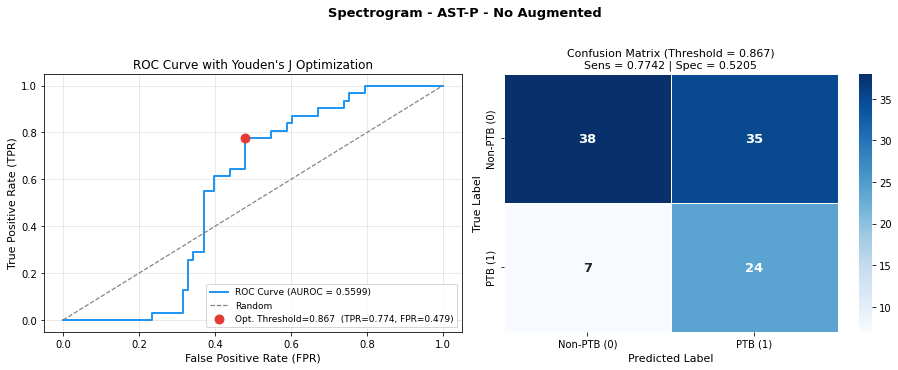

In [23]:
def evaluate_and_visualize(
    ptb_probs  : np.ndarray,
    true_labels: np.ndarray,
    threshold  = 'auto',          # เปลี่ยน Default เป็น 'auto'
    best_epoch : int   = 0,
    best_mauc  : float = 0.0,
    save_path  : str   = None,
):
    """
    คำนวณ AUROC / AUPRC / Sensitivity / Specificity
    และวาดกราฟ ROC Curve + Confusion Matrix พร้อมหา Optimal Threshold ด้วย Youden's J
    """
    CLASS_NAMES = ["Non-PTB (0)", "PTB (1)"]

    # ── 1. คำนวณ ROC และหา Optimal Threshold ────────────────────────────────────
    fpr, tpr, thresholds_roc = roc_curve(true_labels, ptb_probs)
    auroc = roc_auc_score(true_labels, ptb_probs)
    auprc = average_precision_score(true_labels, ptb_probs)

    # หากตั้งเป็น 'auto' ให้ใช้ Youden's J Index หาค่าที่ดีที่สุด
    if threshold == 'auto':
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds_roc[optimal_idx]
        print(f"[INFO] Auto-optimized threshold using Youden's J: {optimal_threshold:.4f}")
        threshold = optimal_threshold

    # ── 2. คำนวณ Metrics ที่ Threshold ที่เลือก ──────────────────────────────────
    pred_labels = (ptb_probs >= threshold).astype(int)
    cm = confusion_matrix(true_labels, pred_labels)

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  
    accuracy    = (tp + tn) / len(true_labels)

    print("=" * 55)
    print("          AST-P PERFORMANCE SUMMARY")
    print("=" * 55)
    print(f"  Threshold     : {threshold:.4f}")
    print("-" * 55)
    print(f"  AUROC         : {auroc:.4f}")
    print(f"  AUPRC         : {auprc:.4f}")
    print(f"  Accuracy      : {accuracy:.4f}")
    print(f"  Sensitivity   : {sensitivity:.4f}  (TPR / Recall)")
    print(f"  Specificity   : {specificity:.4f}  (TNR)")
    print("-" * 55)
    print(f"  TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print("=" * 55)

    # ── 3. Plot กราฟ ────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    fig.suptitle(
        f"Spectrogram - AST-P - No Augmented",
        fontsize=13, fontweight="bold", y=1.02
    )

    # Left: ROC Curve
    ax_roc = axes[0]
    ax_roc.plot(fpr, tpr, color="#2196F3", lw=2, label=f"ROC Curve (AUROC = {auroc:.4f})")
    ax_roc.plot([0, 1], [0, 1], color="gray", lw=1.2, linestyle="--", label="Random")

    # วาดจุด Operating Point 
    op_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    op_tpr = sensitivity
    ax_roc.scatter(
        op_fpr, op_tpr,
        s=80, color="#E53935", zorder=5,
        label=f"Opt. Threshold={threshold:.3f}  (TPR={op_tpr:.3f}, FPR={op_fpr:.3f})"
    )

    ax_roc.set_xlabel("False Positive Rate (FPR)", fontsize=11)
    ax_roc.set_ylabel("True Positive Rate (TPR)", fontsize=11)
    ax_roc.set_title("ROC Curve with Youden's J Optimization", fontsize=12)
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(True, alpha=0.35)

    # Right: Confusion Matrix
    ax_cm = axes[1]
    import seaborn as sns
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax_cm,
        linewidths=0.5, linecolor="white", annot_kws={"size": 13, "weight": "bold"},
    )
    ax_cm.set_xlabel("Predicted Label", fontsize=11)
    ax_cm.set_ylabel("True Label",      fontsize=11)
    ax_cm.set_title(
        f"Confusion Matrix (Threshold = {threshold:.3f})\n"
        f"Sens = {sensitivity:.4f} | Spec = {specificity:.4f}",
        fontsize=11
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

    return {
        "auroc": auroc, "auprc": auprc, "accuracy": accuracy,
        "sensitivity": sensitivity, "specificity": specificity,
        "optimal_threshold": threshold,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
    }

# ── Execute ───────────────────────────────────────────────────────────────────
# วิธีเรียกใช้ (ปล่อย threshold ให้เป็น 'auto')
METRICS = evaluate_and_visualize(
    ptb_probs   = PTB_PROBS,
    true_labels = TRUE_LABELS,
    threshold   = 'auto',   # <--- ให้ฟังก์ชันคำนวณให้
    best_epoch  = BEST_EPOCH,
    best_mauc   = BEST_MAUC,
    save_path   = f"{EXP_DIR}/plots/roc_cm_optimized.png",
)

---

## References

### AST Model

> **Gong, Y., Chung, Y.-A., & Glass, J. (2021).**  
> *AST: Audio Spectrogram Transformer.*  
> Interspeech 2021. [https://arxiv.org/abs/2104.01778](https://arxiv.org/abs/2104.01778)

### Normalization Statistics (AudioSet)

| Parameter | Value | Source |
|-----------|-------|--------|
| **Mean** | −4.2677393 | Computed from full AudioSet (~2M clips) — reported in AST paper |
| **Std**  |  4.5689974 | Computed from full AudioSet (~2M clips) — reported in AST paper |

> ค่าเหล่านี้ใช้เพื่อ Normalize Log-Mel Filterbank Features ก่อนป้อนเข้าโมเดล:  
> `normalized = (fbank − mean) / (std × 2)`  
> (ดู `src/dataloader.py`, Line ~87)

### SpecAugment

> **Park, D. S., et al. (2019).**  
> *SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition.*  
> Interspeech 2019. [https://arxiv.org/abs/1904.08779](https://arxiv.org/abs/1904.08779)

### MixUp

> **Zhang, H., et al. (2018).**  
> *Mixup: Beyond Empirical Risk Minimization.*  
> ICLR 2018. [https://arxiv.org/abs/1710.09412](https://arxiv.org/abs/1710.09412)

### Vision Transformer (ViT) — Backbone ของ AST

> **Dosovitskiy, A., et al. (2020).**  
> *An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale.*  
> ICLR 2021. [https://arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)

### ImageNet Pretrained Weights

> AST-P ใช้ Weights จาก DeiT ที่ Pre-train บน ImageNet (384×384)  
> ผ่าน `timm` library, version **0.4.5** (`timm.create_model("deit_base_distilled_patch16_384")`)

---

_Notebook นี้พัฒนาสำหรับงาน TB Cough Detection โดยใช้สถาปัตยกรรม AST-P_
